In [1]:
import sys
sys.path.append('../src/analysis-of-global-ocean')
%load_ext autoreload
%autoreload 3

import xarray as xr
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar

from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.computational_tools import *
from helpers.plot_helpers import default_rcParams

In [3]:
ds = CollectionOfExperiments.init_folder('/scratch/js15017/OM4_storage/CORE-AIF-runs', additional_subfolder='', Averaging_time=slice('1981', '2007'))

## OM4 grid information

In [5]:
param = ds['unparameterized'].param
dz = ds['unparameterized'].dz
mask_nan = xr.where(np.isnan(ds['MEKE-Chang'].ocean_annual_z.thetao.isel(time=0)), np.nan, 1.).compute()
dV = mask_nan * param.areacello * dz

## Globally-average potential temperature

In [12]:
# Define 3D average
def ave(x):
    return (x * dV).sum(['zl','xh','yh']) / dV.sum(['zl', 'xh', 'yh'])

In [13]:
obs = xr.open_dataset('../src/analysis-of-global-ocean/data/woa18_decav81B0_t00_01.nc', decode_times=False).squeeze()

In [18]:
# 3D average for observations
dz_obs = xr.DataArray(np.diff(obs.depth_bnds,1).squeeze(), dims='depth')

# WOA uses 1-degree grid
lon_spacing = 1
lat_spacing = 1
R_earth = 6.378e+6 # Radius of earth in metres

dx_obs = np.deg2rad(lon_spacing) * R_earth * np.cos(np.deg2rad(obs.lat))
dy_obs = np.deg2rad(lat_spacing) * R_earth
mask_nan = xr.where(np.isnan(obs.t_an), np.nan, 1.).compute()
dV_obs = mask_nan * dx_obs * dy_obs * dz_obs

def ave_obs(x):
    return (x * dV_obs).sum(['depth','lon','lat']) / dV_obs.sum(['depth', 'lon', 'lat'])

In [36]:
# Dictionary with metrics of global circulation
metrics_dict = {}

In [37]:
#WOA 18
metrics_dict['temp-obs'] = float(ave_obs(obs.t_an))

In [38]:
# Compute global-averaged time series
with ProgressBar():
    for exp in ['unparameterized', 'ANN', 'MEKE-Chang']:
        metrics_dict[f'temp-{exp}'] = float(ave(ds[exp].ocean_annual_z.thetao).sel(time=slice('1981','2007')).mean('time'))

[########################################] | 100% Completed | 9.38 ss
[########################################] | 100% Completed | 8.47 ss
[########################################] | 100% Completed | 7.77 ss


In [39]:
metrics_dict

{'temp-obs': 3.679951219264243,
 'temp-unparameterized': 3.442140593465002,
 'temp-ANN': 3.3422429933964417,
 'temp-MEKE-Chang': 3.3728002115996145}

## KE and APE 

In [40]:
for exp in ['unparameterized', 'ANN', 'MEKE-Chang']:
    metrics_dict[f'KE-{exp}'] = ds[exp].series.KE.sum('Layer')[-27*365*4:].mean().data * 1e-18
    metrics_dict[f'APE-{exp}'] = ds[exp].series.APE.sum('Interface')[-27*365*4:].mean().data * 1e-20

In [41]:
metrics_dict

{'temp-obs': 3.679951219264243,
 'temp-unparameterized': 3.442140593465002,
 'temp-ANN': 3.3422429933964417,
 'temp-MEKE-Chang': 3.3728002115996145,
 'KE-unparameterized': 2.721916443209208,
 'APE-unparameterized': 3.880766853530472,
 'KE-ANN': 3.9054452982347043,
 'APE-ANN': 3.6427134435923083,
 'KE-MEKE-Chang': 3.597673811836249,
 'APE-MEKE-Chang': 3.6433594199240464}

## ACC transport

In [42]:
# See cDrake also for error bounds https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2016GL070319
metrics_dict['ACC-obs'] = 173.3

In [43]:
# ACC transport at 70W
for exp in ['unparameterized', 'ANN', 'MEKE-Chang']:
    metrics_dict[f'ACC-{exp}'] = float(1e-9 * ds[exp].ocean_annual_z.umo.sel(xq=-70, method='nearest').sel(yh=slice(-71,-54.5)).sum(['yh','zl']).sel(time=slice('1981','2007')).mean('time'))

In [45]:
metrics_dict

{'temp-obs': 3.679951219264243,
 'temp-unparameterized': 3.442140593465002,
 'temp-ANN': 3.3422429933964417,
 'temp-MEKE-Chang': 3.3728002115996145,
 'KE-unparameterized': 2.721916443209208,
 'APE-unparameterized': 3.880766853530472,
 'KE-ANN': 3.9054452982347043,
 'APE-ANN': 3.6427134435923083,
 'KE-MEKE-Chang': 3.597673811836249,
 'APE-MEKE-Chang': 3.6433594199240464,
 'ACC-obs': 173.3,
 'ACC-unparameterized': 154.56248474121094,
 'ACC-ANN': 126.55327606201172,
 'ACC-MEKE-Chang': 126.72998809814453}

# AMOC strength

In [56]:
# AMOC RAPID yearly averaged 2004-2021
metrics_dict['AMOC-obs'] = float(xr.open_dataset('../src/analysis-of-global-ocean/data/AMOC_26p5_max_RAPID_annual_2004-2021.nc').AMOC.mean('time'))

In [108]:
#RAPID std:
xr.open_dataset('../src/analysis-of-global-ocean/data/AMOC_26p5_max_RAPID_annual_2004-2021.nc').AMOC.std('time')

<xarray.DataArray 'AMOC' ()> Size: 8B
array(1.43214452)

In [51]:
# Compute AMOC with the package
# We first compute maximum at lat 26.5N, and only then mean. Same as observational data.
with ProgressBar():
    for exp in ['unparameterized', 'ANN', 'MEKE-Chang']:
        metrics_dict[f'AMOC-{exp}'] = float(ds[exp].AMOC_new.sel(yq=26.5,method='nearest').sel(time=slice('1981','2007')).max('zi').mean('time'))

[########################################] | 100% Completed | 11.62 ss
[########################################] | 100% Completed | 24.49 s
[########################################] | 100% Completed | 24.71 s


In [74]:
for metric in ['KE', 'APE', 'temp', 'ACC', 'AMOC']:
    print(metric, ': ', end="") 
    for exp in ['unparameterized', 'ANN', 'MEKE-Chang', 'obs']:
        try:
            print(exp, " = ", "%.2f" % metrics_dict[f'{metric}-{exp}'], ", ", end="")
        except:
            pass

    print()

KE : unparameterized  =  2.72 , ANN  =  3.91 , MEKE-Chang  =  3.60 , 
APE : unparameterized  =  3.88 , ANN  =  3.64 , MEKE-Chang  =  3.64 , 
temp : unparameterized  =  3.44 , ANN  =  3.34 , MEKE-Chang  =  3.37 , obs  =  3.68 , 
ACC : unparameterized  =  154.56 , ANN  =  126.55 , MEKE-Chang  =  126.73 , obs  =  173.30 , 
AMOC : unparameterized  =  15.42 , ANN  =  13.19 , MEKE-Chang  =  13.85 , obs  =  16.85 , 


In [77]:
with open("data/metrics_dict.json", "w") as f:
    json.dump(metrics_dict, f) 

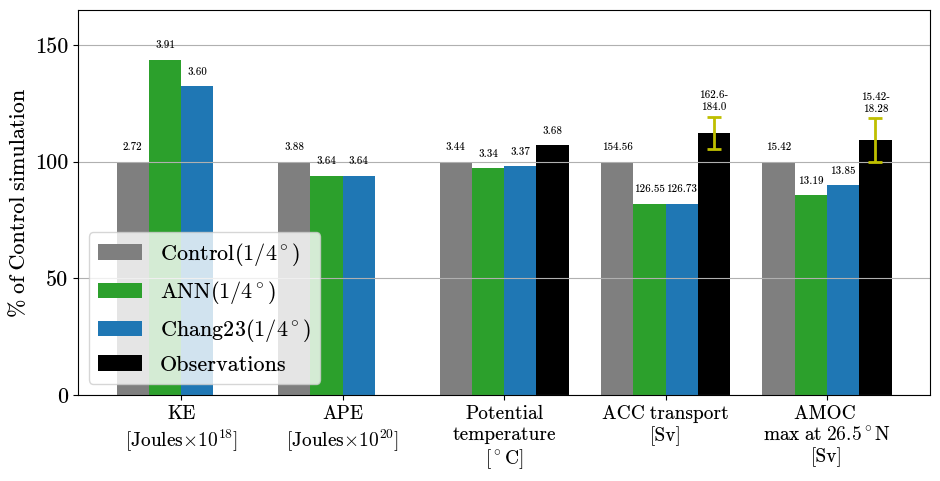

In [14]:
default_rcParams(
    {   'font.family': 'MathJax_Main',
        'mathtext.fontset': 'cm',

        'axes.formatter.use_mathtext': True,
        
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        'font.size': 16}
)

import matplotlib.pyplot as plt
import numpy as np

# Metric labels
metrics = ['KE\n[Joules$\\times10^{18}$]', 'APE\n[Joules$\\times10^{20}$]', 'Potential\ntemperature\n[$^\circ$C]', 'ACC transport\n[Sv]', 'AMOC \nmax at $26.5^\circ$N\n[Sv]']

# Raw values of metrics for three models and observations
model_a_raw = [2.72, 3.88, 3.44, 154.56, 15.42]
model_b_raw = [3.91, 3.64, 3.34, 126.55, 13.19]
model_c_raw = [3.60, 3.64, 3.37, 126.73, 13.85]
obs_raw     = [np.nan, np.nan, 3.68, 173.30, 16.85]
obs_errors_raw = [np.nan, np.nan, np.nan, 10.7, 1.43]

# Observations always have the bar of same height
model_a = np.array(model_a_raw) / np.array(model_a_raw)
model_b = np.array(model_b_raw) / np.array(model_a_raw)
model_c = np.array(model_c_raw) / np.array(model_a_raw)
obs = np.array(obs_raw) / np.array(model_a_raw)
obs_errors = obs_errors_raw / np.array(model_a_raw)

# Bar plot setup
x = np.arange(len(metrics))
width = 0.2  # Adjust width for 4 bars

fig, ax = plt.subplots(figsize=(11, 5))

# Plot bars
ax.bar(x - 1.5*width, model_a, width, label='Control($1/4^\circ$)', color='tab:gray')
ax.bar(x - 0.5*width, model_b, width, label='ANN($1/4^\circ$)', color='tab:green')
ax.bar(x + 0.5*width, model_c, width, label='Chang23($1/4^\circ$)', color='tab:blue')
ax.bar(x + 1.5*width, obs, width, label='Observations', color='k', yerr=obs_errors, error_kw=dict(ecolor='y', capsize=5, lw=2, capthick=2))

# X-axis labels
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=0, fontsize=14)

# Remove y-axis
ax.set_yticks([0,0.5,1,1.5,2.0], ['0','50', '100', '150','200'])
ax.set_ylabel('% of Control simulation')

# Title and legend
#ax.set_title('Comparison of ANN to Chang et. al 2023 in global ocean model OM4', fontsize=12)
ax.legend(loc='lower left')

# Optional: Add bar value labels
for idx in range(len(metrics)):
    ax.text(x[idx] - 1.5*width, model_a[idx] + 0.05, f'{model_a_raw[idx]:.2f}', ha='center', fontsize=8)
    ax.text(x[idx] - 0.5*width, model_b[idx] + 0.05, f'{model_b_raw[idx]:.2f}', ha='center', fontsize=8)
    ax.text(x[idx] + 0.5*width, model_c[idx] + 0.05, f'{model_c_raw[idx]:.2f}', ha='center', fontsize=8)
    if np.isnan(obs[idx]):
        pass
    else:
        if idx==3:
            ax.text(x[idx] + 1.5*width, obs[idx] + 0.1, '162.6-\n184.0', ha='center', fontsize=8)
        elif idx==4:
            ax.text(x[idx] + 1.5*width, obs[idx] + 0.12, '15.42-\n18.28', ha='center', fontsize=8)
        else:
            ax.text(x[idx] + 1.5*width, obs[idx] + 0.05, f'{obs_raw[idx]:.2f}', ha='center', fontsize=8)

plt.ylim([0, 1.65])
plt.grid(axis='y')
plt.savefig('figures/Figure-4.pdf', bbox_inches='tight')